Currently doing Bounding Box Detection For cornea/iris pair number:cornea_cnn_a (42).png


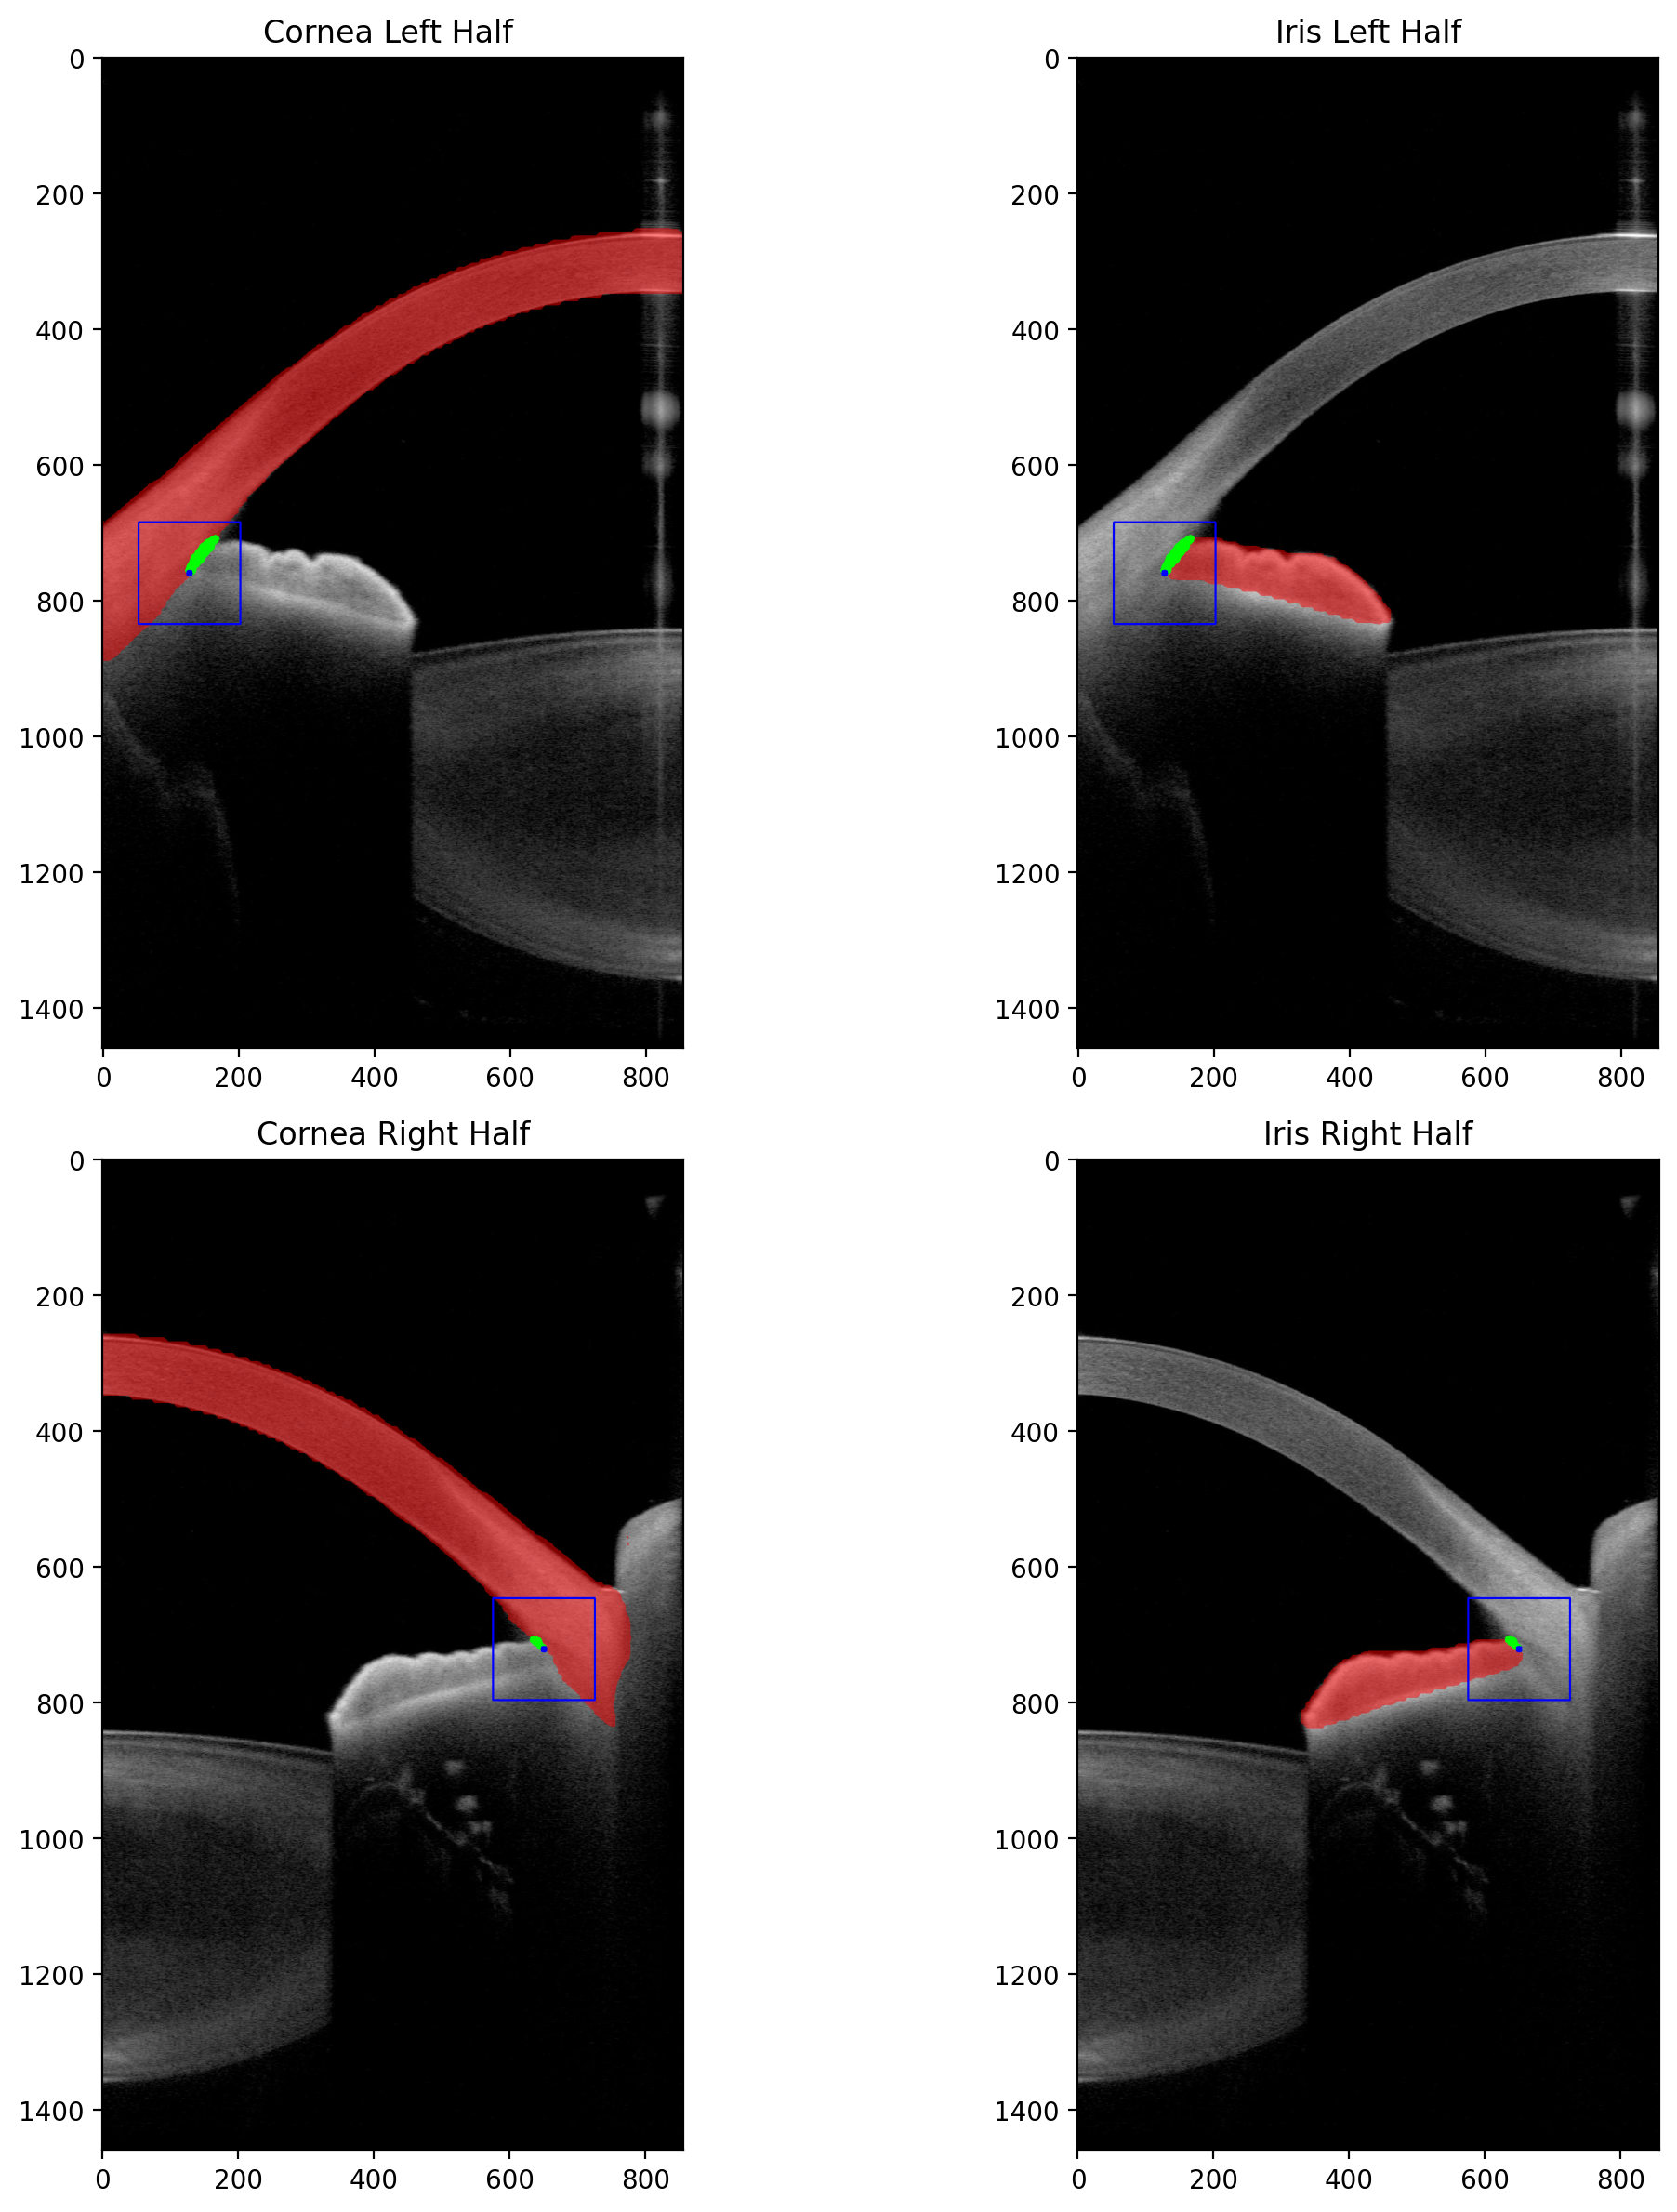

Currently doing Bounding Box Detection For cornea/iris pair number:cornea_cnn_a (54).png
No intersection points found in the right half. Estimating Using Dilation


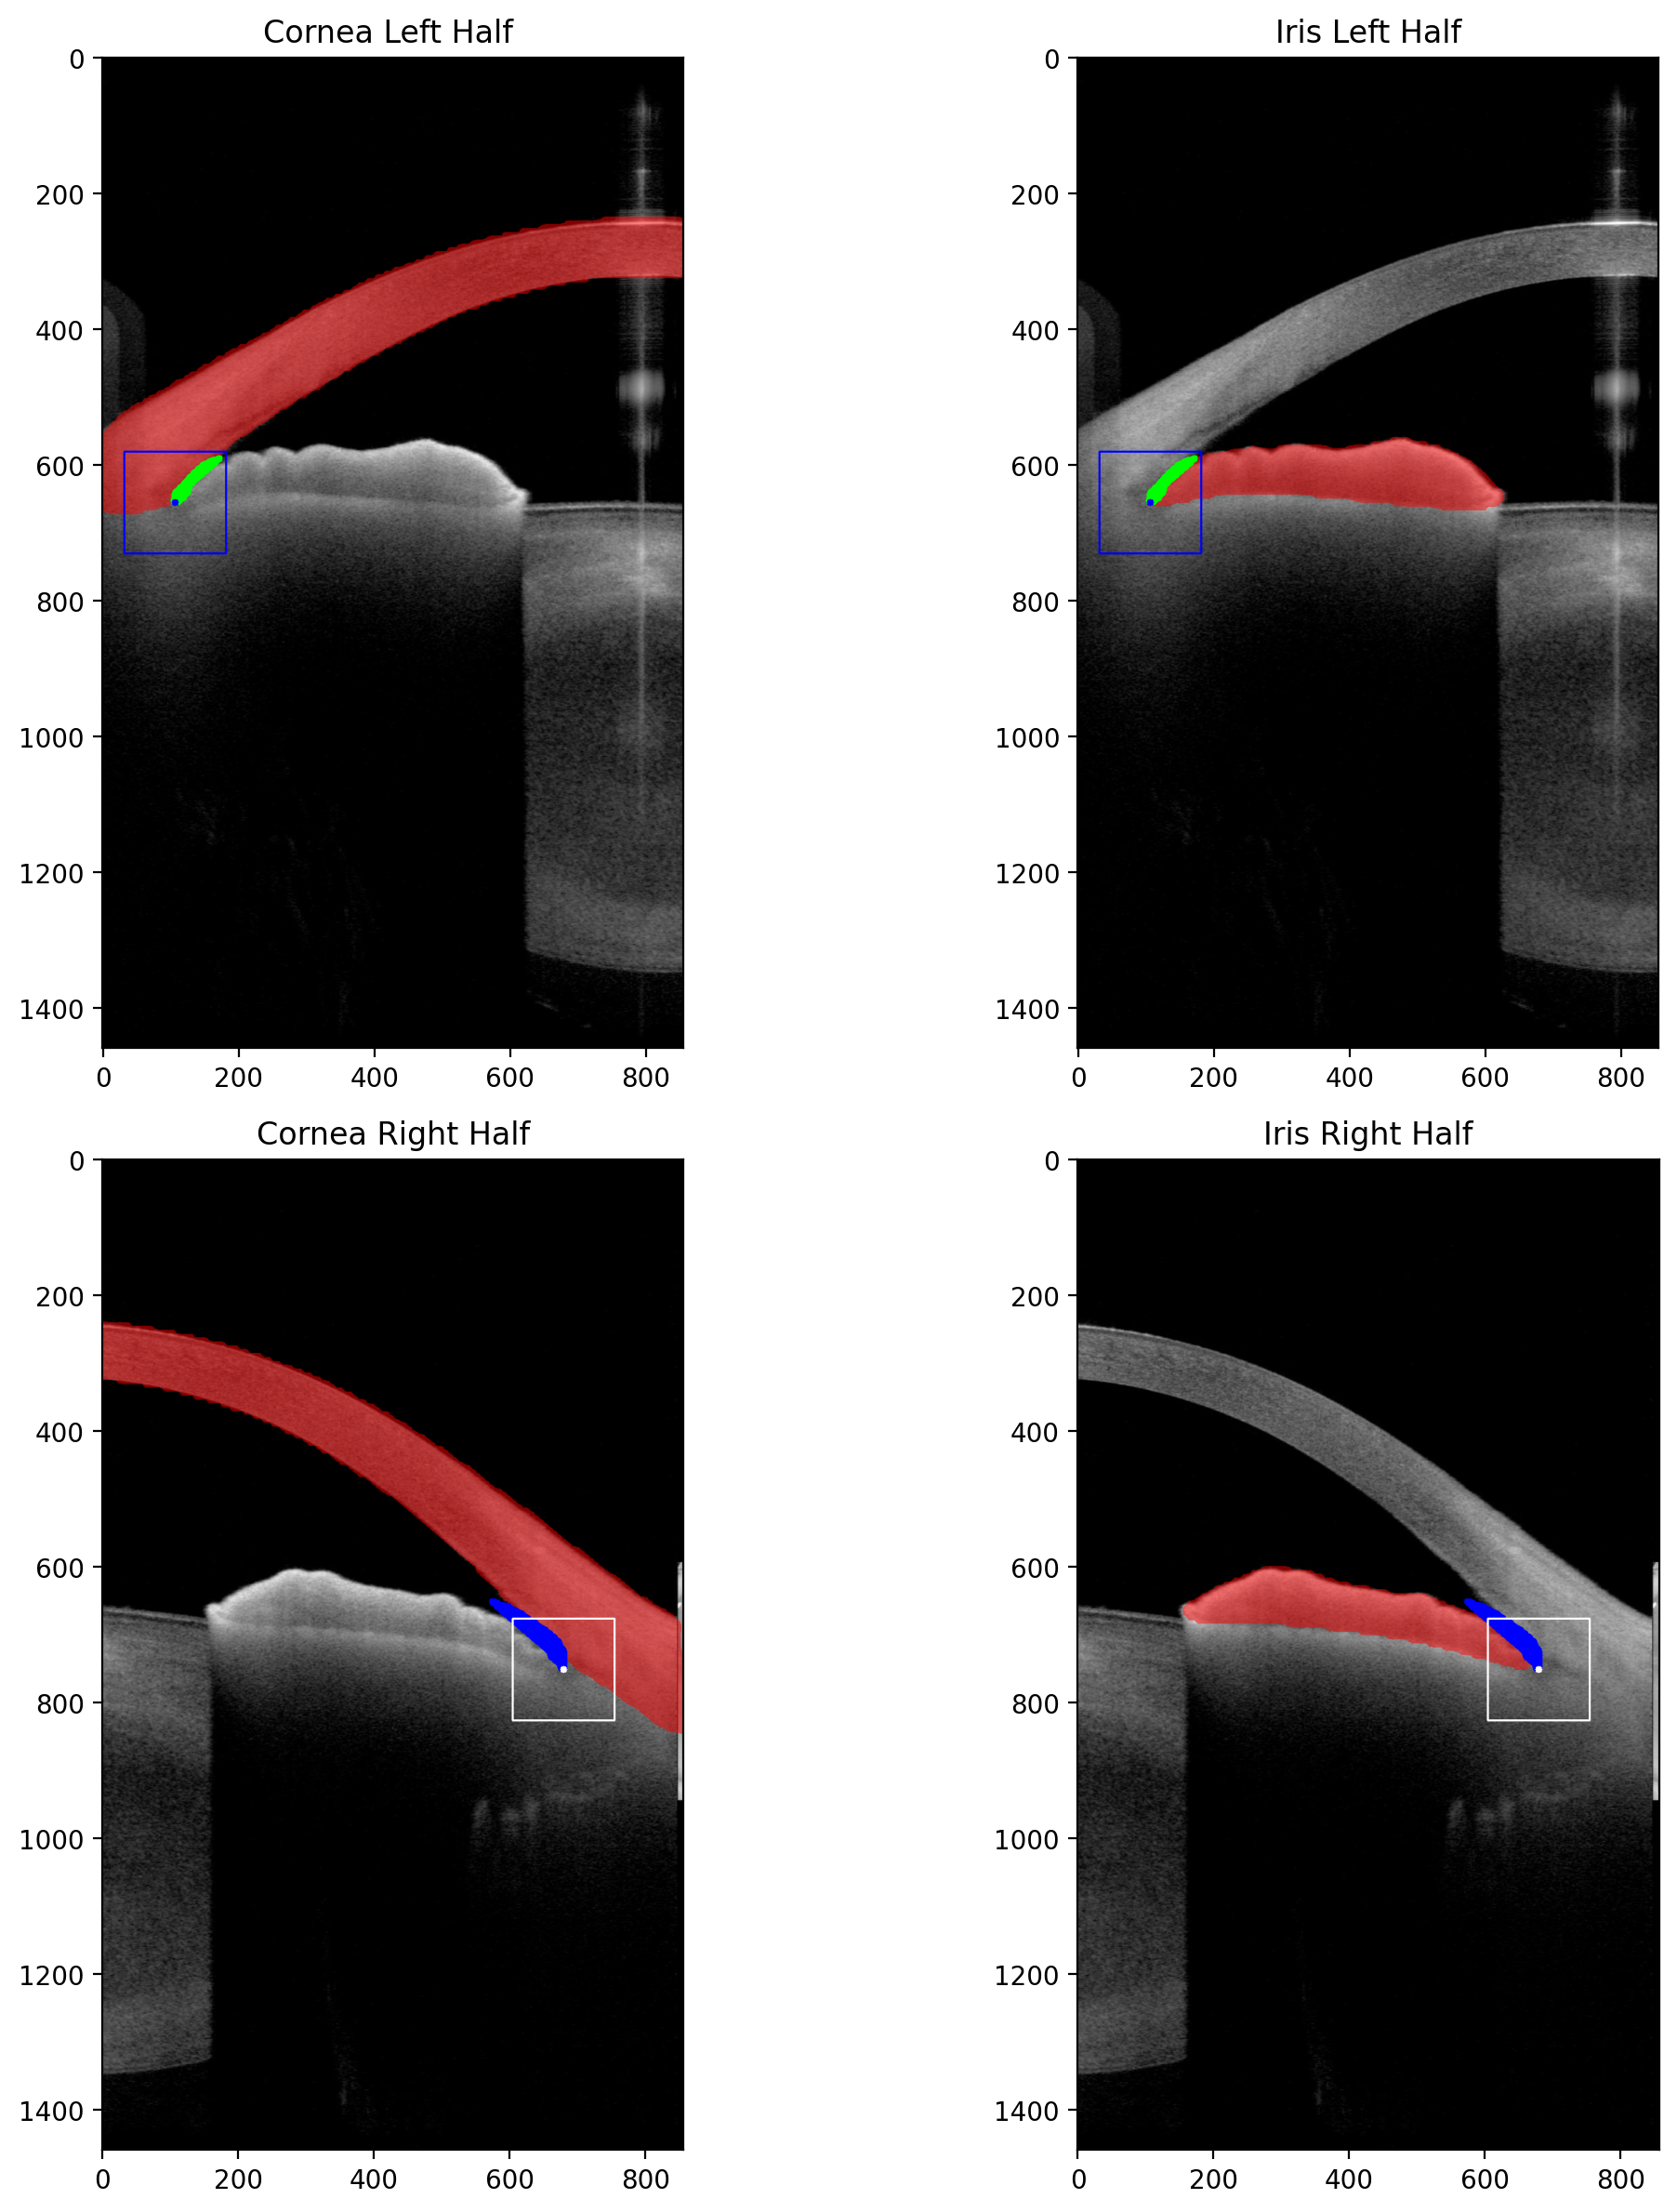

Currently doing Bounding Box Detection For cornea/iris pair number:cornea_cnn_a (78).png


In [3]:
# boundingBox.ipynb
# Creates bounding boxes around iris and cornea on SM OCT images
# @author: Seena Pourzand
# @date: 26 November 2023
# IPILAB USC


# problematic case is folder SSA007_OS_Scan2_10 in DEFAULT or number 83 in my local folder

import os
from os import listdir #for iteration

import numpy as np
import cv2
from skimage.io import imread, imshow
from skimage.color import rgb2hsv
import matplotlib.pyplot as plt #for segmentation

from skimage.segmentation import flood_fill # for region grow

from PIL import Image #for saving image


def find_closest_points(cornea_mask, iris_mask):
    closest_distance = float('inf')
    closest_cornea_point = None
    closest_iris_point = None

    for i in range(cornea_mask.shape[0]):
        for j in range(cornea_mask.shape[1]):
            if cornea_mask[i, j] > 0:
                for m in range(iris_mask.shape[0]):
                    for n in range(iris_mask.shape[1]):
                        if iris_mask[m, n] > 0:
                            distance = np.sqrt((i - m) ** 2 + (j - n) ** 2)
                            if distance < closest_distance:
                                closest_distance = distance
                                closest_cornea_point = (i, j)
                                closest_iris_point = (m, n)

    return closest_cornea_point, closest_iris_point


# print("Loading image..")
# corneaSegmentationImg = "/Users/seena/Downloads/DEFAULT/SSA004_OS_Scan3_11/eval/image/cornea_cnn_a.png"

# scan = plt.imread(corneaSegmentationImg)
# plt.imshow(scan)
# print("Convering to hsv")
# scan_hsv = rgb2hsv(scan[...,0:3]) # since the png images are 4 channels 
# plt.imshow(scan_hsv)


# ---------------------------------
# old flood fill/region grow code 
# img = "/Users/seena/Desktop/OCT_image.png"
# scan = plt.imread(img)
# print("Convering to hsv")
# scan_hsv = rgb2hsv(scan[...,0:3]) # since the png images are 4 channels 
# filledImage = flood_fill(img,[72,358],50)
# imshow(filledImage)

# ---------------------------------

# Load the two images with red segmentations

#PUT YOUR LOCAL PATH HERE
# corneaImg = cv2.imread('/Users/seena/Downloads/SM_image_database/cornea_cnn_a.png')
# irisImg = cv2.imread('/Users/seena/Downloads/SM_image_database/IRIS_a.png')

# corneaImg = cv2.imread('/Users/seena/Downloads/SM_image_database/cornea_cnn_a (6).png')
# irisImg = cv2.imread('/Users/seena/Downloads/SM_image_database/iris_cnn_a (6).png')

num_natural = 0
num_dilated = 0

# Define the path to the folder containing the images
folder_path = '/Users/seena/Downloads/SM_image_database_recovered/'
# folder_path = '/Users/seena/Downloads/SM_image_database/'


# Process each file in the folder
cornea_files = [f for f in os.listdir(folder_path) if f.startswith('cornea_cnn_a') and f.endswith('.png')]

# Process each cornea file in the folder
for cornea_file in cornea_files:
    print("Currently doing Bounding Box Detection For cornea/iris pair number:{}".format(cornea_file))
    cornea_path = os.path.join(folder_path, cornea_file)
    
    # Generate the corresponding iris file path
    iris_file = cornea_file.replace('cornea_cnn_a', 'iris_cnn_a')
    iris_path = os.path.join(folder_path, iris_file)

    corneaImg = cv2.imread(cornea_path)
    irisImg = cv2.imread(iris_path)

    # Get the height and width of the images
    height, width, _ = corneaImg.shape # Underscore just let's us ignore the values

    # Split the images into two halves along the y-axis
    half_width = width // 2 # Floor division
    corneaImg_left_half = corneaImg[:, :half_width]
    corneaImg_right_half = corneaImg[:, half_width:]
    irisImg_left_half = irisImg[:, :half_width]
    irisImg_right_half = irisImg[:, half_width:]

    # Convert the images to the HSV color space
    hsv_corneaImg_left_half = cv2.cvtColor(corneaImg_left_half, cv2.COLOR_BGR2HSV)
    hsv_corneaImg_right_half = cv2.cvtColor(corneaImg_right_half, cv2.COLOR_BGR2HSV)
    hsv_irisImg_left_half = cv2.cvtColor(irisImg_left_half, cv2.COLOR_BGR2HSV)
    hsv_irisImg_right_half = cv2.cvtColor(irisImg_right_half, cv2.COLOR_BGR2HSV)

    # Define the lower and upper HSV values for the red color
    lower_red = np.array([0, 100, 100])
    upper_red = np.array([10, 255, 255])

    # Create binary masks for the red regions in both left halves
    mask1_left_half = cv2.inRange(hsv_corneaImg_left_half, lower_red, upper_red)
    mask2_left_half = cv2.inRange(hsv_irisImg_left_half, lower_red, upper_red)
    # print("prep")
    # print(sum(mask1_left_half))
    # print("done")
    # Create binary masks for the red regions in both right halves
    mask1_right_half = cv2.inRange(hsv_corneaImg_right_half, lower_red, upper_red)
    mask2_right_half = cv2.inRange(hsv_irisImg_right_half, lower_red, upper_red)

    # Find the common regions (intersection) between the left halves
    intersection_mask_left = cv2.bitwise_and(mask1_left_half, mask2_left_half)

    # Find the common regions (intersection) between the right halves
    intersection_mask_right = cv2.bitwise_and(mask1_right_half, mask2_right_half)

    # Find the coordinates (points) where the left halves intersect
    intersection_points_left = np.column_stack(np.where(intersection_mask_left > 0))

    # Find the coordinates (points) where the right halves intersect
    intersection_points_right = np.column_stack(np.where(intersection_mask_right > 0))

    # Overlay the points of intersection on the original images
    for point in intersection_points_left:
        cv2.circle(corneaImg_left_half, tuple(reversed(point)), 5, (0, 255, 0), -1)
        cv2.circle(irisImg_left_half, tuple(reversed(point)), 5, (0, 255, 0), -1)

    for point in intersection_points_right:
        cv2.circle(corneaImg_right_half, tuple(reversed(point)), 5, (0, 255, 0), -1)
        cv2.circle(irisImg_right_half, tuple(reversed(point)), 5, (0, 255, 0), -1)

    box_size = (150, 150)  # Adjust the size of the bounding box as needed


    # Wasil suggested
    # IF NO OVERLAP, use dialation (morohology) or region grow, depends on structuring element for dilation

    # Determine the bottom leftmost point for the left half
    if len(intersection_points_left) > 0:
        bottom_leftmost_point_left = tuple(intersection_points_left[np.argmax(intersection_points_left[:, 0])])
        cv2.circle(corneaImg_left_half, tuple(reversed(bottom_leftmost_point_left)), 5, (255, 0, 0), -1)
        cv2.circle(irisImg_left_half, tuple(reversed(bottom_leftmost_point_left)), 5, (255, 0, 0), -1)

        top_left = (bottom_leftmost_point_left[1] - box_size[1] // 2, bottom_leftmost_point_left[0] - box_size[0] // 2)
        bottom_right = (bottom_leftmost_point_left[1] + box_size[1] // 2, bottom_leftmost_point_left[0] + box_size[0] // 2)

        # Draw the rectangular bounding box in blue for rn
        cv2.rectangle(corneaImg_left_half, top_left, bottom_right, (255, 0, 0), 2)  # (0, 0, 255) for red, 2 for thickness
        cv2.rectangle(irisImg_left_half, top_left, bottom_right, (255, 0, 0), 2)  # (0, 0, 255) for red, 2 for thickness

        num_natural+=1

    else:

        num_dilated+=1
        print("No intersection points found in the left half. Estimating Using Dilation")
        dilation_iterations = 5  # Increase or decrease as necessary

        # Create structuring elements for dilation
        kernel = np.ones((5, 5), np.uint8)  # You can adjust the kernel size

        while ( len(intersection_points_left) <= 0):
            
            # Perform dilation on both masks
            dilated_mask1 = cv2.dilate(mask1_left_half, kernel, iterations=dilation_iterations)
            dilated_mask2 = cv2.dilate(mask2_left_half, kernel, iterations=dilation_iterations)

            # Find the common region by taking the bitwise AND of the two dilated masks
            intersection_mask_left = cv2.bitwise_and(dilated_mask1, dilated_mask2)

            # Find the coordinates (points) where the left halves intersect after dilation
            intersection_points_left = np.column_stack(np.where(intersection_mask_left > 0))
            dilation_iterations+=5

        # print("intersection now?")
        # print(len(intersection_points_left))
        #--repeat code
        #coloring in
        for point in intersection_points_left:
            cv2.circle(corneaImg_left_half, tuple(reversed(point)), 5, (255, 0, 0), -1)
            cv2.circle(irisImg_left_half, tuple(reversed(point)), 5, (255, 0, 0), -1)

        bottom_leftmost_point_left = tuple(intersection_points_left[np.argmax(intersection_points_left[:, 0])])
        cv2.circle(corneaImg_left_half, tuple(reversed(bottom_leftmost_point_left)), 5, (255, 255, 255), -1)
        cv2.circle(irisImg_left_half, tuple(reversed(bottom_leftmost_point_left)), 5, (255, 255, 255), -1)

        top_left = (bottom_leftmost_point_left[1] - box_size[1] // 2, bottom_leftmost_point_left[0] - box_size[0] // 2)
        bottom_right = (bottom_leftmost_point_left[1] + box_size[1] // 2, bottom_leftmost_point_left[0] + box_size[0] // 2)

        # Draw the rectangular bounding box in blue for right now
        cv2.rectangle(corneaImg_left_half, top_left, bottom_right, (255, 255, 255), 2)  # (0, 0, 255) for red, 2 for thickness
        cv2.rectangle(irisImg_left_half, top_left, bottom_right, (255, 255, 255), 2)  # (0, 0, 255) for red, 2 for thickness



        #--repeat code



    # Determine the bottom rightmost point for the right half
    if len(intersection_points_right) > 0:
        bottom_rightmost_point_right = tuple(intersection_points_right[np.argmax(intersection_points_right[:, 0])])
        cv2.circle(corneaImg_right_half, tuple(reversed(bottom_rightmost_point_right)), 5, (255, 0, 0), -1)
        cv2.circle(irisImg_right_half, tuple(reversed(bottom_rightmost_point_right)), 5, (255, 0, 0), -1)


        top_left = (bottom_rightmost_point_right[1] - box_size[1] // 2, bottom_rightmost_point_right[0] - box_size[0] // 2)
        bottom_right = (bottom_rightmost_point_right[1] + box_size[1] // 2, bottom_rightmost_point_right[0] + box_size[0] // 2)

        # Draw the rectangular bounding box in blue for rn
        cv2.rectangle(corneaImg_right_half, top_left, bottom_right, (255, 0, 0), 2)  # (0, 0, 255) for red, 2 for thickness
        cv2.rectangle(irisImg_right_half, top_left, bottom_right, (255, 0, 0), 2)  # (0, 0, 255) for red, 2 for thickness

        num_natural+=1

    else:
        num_dilated+=1
        print("No intersection points found in the right half. Estimating Using Dilation")
        dilation_iterations = 5  # Increase or decrease as necessary

        # Create structuring elements for dilation
        kernel = np.ones((5, 5), np.uint8)  # You can adjust the kernel size


        while ( len(intersection_points_right) <= 0):
            # Perform dilation on both masks for the right half
            dilated_mask1_right_half = cv2.dilate(mask1_right_half, kernel, iterations=dilation_iterations)
            dilated_mask2_right_half = cv2.dilate(mask2_right_half, kernel, iterations=dilation_iterations)

            # Find the common region by taking the bitwise AND of the two dilated masks for the right half
            intersection_mask_right = cv2.bitwise_and(dilated_mask1_right_half, dilated_mask2_right_half)

            # Find the coordinates (points) where the right halves intersect after dilation
            intersection_points_right = np.column_stack(np.where(intersection_mask_right > 0))
            dilation_iterations+=5
        # print("intersection now?")
        # print(len(intersection_points_right))
        # --repeat code
        # coloring in
        for point in intersection_points_right:
            cv2.circle(corneaImg_right_half, tuple(reversed(point)), 5, (255, 0, 0), -1)
            cv2.circle(irisImg_right_half, tuple(reversed(point)), 5, (255, 0, 0), -1)

        bottom_rightmost_point_right = tuple(intersection_points_right[np.argmax(intersection_points_right[:, 0])])
        cv2.circle(corneaImg_right_half, tuple(reversed(bottom_rightmost_point_right)), 5, (255, 255, 255), -1)
        cv2.circle(irisImg_right_half, tuple(reversed(bottom_rightmost_point_right)), 5, (255, 255, 255), -1)

        top_left = (bottom_rightmost_point_right[1] - box_size[1] // 2, bottom_rightmost_point_right[0] - box_size[0] // 2)
        bottom_right = (bottom_rightmost_point_right[1] + box_size[1] // 2, bottom_rightmost_point_right[0] + box_size[0] // 2)

        # Draw the rectangular bounding box in blue for right now
        cv2.rectangle(corneaImg_right_half, top_left, bottom_right, (255, 255, 255), 2)  # (0, 0, 255) for red, 2 for thickness
        cv2.rectangle(irisImg_right_half, top_left, bottom_right, (255, 255, 255), 2)  # (0, 0, 255) for red, 2 for thickness



    plt.figure(figsize=(12, 12), dpi=200)

    # Display the images with intersection points for the left and right halves
    plt.subplot(221), plt.imshow(cv2.cvtColor(corneaImg_left_half, cv2.COLOR_BGR2RGB))
    plt.title('Cornea Left Half ')
    plt.subplot(222), plt.imshow(cv2.cvtColor(irisImg_left_half, cv2.COLOR_BGR2RGB) )
    plt.title('Iris Left Half')
    plt.subplot(223), plt.imshow(cv2.cvtColor(corneaImg_right_half, cv2.COLOR_BGR2RGB) )
    plt.title('Cornea Right Half')
    plt.subplot(224), plt.imshow(cv2.cvtColor(irisImg_right_half, cv2.COLOR_BGR2RGB) )
    plt.title('Iris Right Half')

    plt.tight_layout()

    plt.show()



    # anshu and brent suggest that I use the furthest aka last point of intersection
    # so for the left half i choose the left most point of overlap.
print("num natural")
print(num_natural)
print("num dialted")
print(num_dilated)
